In [6]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.text import *
from google.colab import drive
drive.mount('/content/drive')

#standard document
path= Path('/content/drive/My Drive/data')
csv_filename='standard_document_binder.csv'
df = pd.read_csv(path/csv_filename).fillna('')[0:100]
generator_text_cols=["title", "text"]
generator_learn_pkl_name='sd_text_lstm_generator_export.pkl'
classifier_feature_cols='text'
classifier_label_cols='category'
classifier_learn_pkl_name='sd_text_lstm_classifier_export.pkl'

'''
#legal qa
text_dir='qa'
csv_filename='legal_qa.csv'
df = pd.read_csv(path/csv_filename).fillna('')
generator_text_cols=["question", "answer"]
generator_learn_pkl_name='qa_text_lstm_generator_export.pkl'
classifier_feature_cols='question'
classifier_label_cols='question_category'
classifier_learn_pkl_name='qa_text_lstm_classifier_export.pkl'
'''
#Courtlistener
'''
text_dir='courtlistener'
csv_filename='cl_scotus_opinions.csv'
df = pd.read_csv(path/csv_filename).fillna('')[0:100]
generator_text_cols=["case_name", "text"]
generator_learn_pkl_name='opinon_text_lstm_generator_export.pkl'
classifier_feature_cols='summary'
classifier_label_cols='category'
classifier_learn_pkl_name='ppinion_text_lstm_classifier_export.pkl'
'''
bs =64
#path= Path('/content/drive/My Drive/data/'+text_dir)
print(df.head(5))
print(df.info())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
                                        uri  ...                                               text
0    guide/785d728aa069a17d71d607079ff1297f  ...                                                   
1     form/c3c16a4d4ee9c52aeee7b2c619f40944  ...  1.1\t<h3>INFORMATION WE COLLECT FROM YOU</h3>\...
2     form/58230dede7b19d717d04cfb91f61ddbf  ...                                                   
3     form/b45c6da243a31401b1c0256dce0be4aa  ...  1.1\t<h3>Acceptance condition</h3>\nValid acce...
4  article/1dd29efd3836d35c9453db25ce004538  ...                                                   

[5 rows x 11 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 11 columns):
uri              100 non-null object
type             100 non-null object
title            100 non-null object
jurisdiction     100 non-null obj

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138 entries, 0 to 137
Data columns (total 11 columns):
uri              138 non-null object
type             138 non-null object
title            138 non-null object
jurisdiction     138 non-null object
resource_type    138 non-null object
category         138 non-null object
subcategory      138 non-null object
tags             138 non-null object
description      138 non-null object
notes            138 non-null object
text             138 non-null object
dtypes: object(11)
memory usage: 12.0+ KB
None


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,time
0,3.713249,3.186851,0.377593,00:08


epoch,train_loss,valid_loss,accuracy,time
0,2.891797,2.760090,0.447810,00:11


Classifier learning begin.


TypeError: ignored

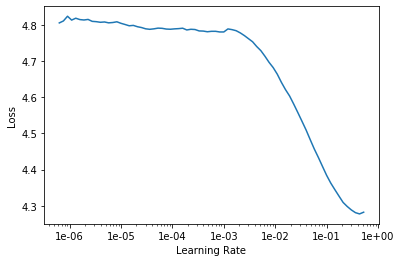

In [5]:

print(df.info())
np.random.seed(42)
lm_df = df.iloc[np.random.permutation(len(df))]
cut = int(0.2 * len(lm_df)) +1
train_lm_df, valid_lm_df = lm_df[cut:], lm_df[:cut]
data_lm = TextLMDataBunch.from_df(path, train_lm_df, valid_lm_df, text_cols=generator_text_cols,
                                  mark_fields=True,
                                  bs=bs)
data_lm.save('data_lm.pkl')
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)
learn.lr_find()
learn.recorder.plot(skip_end=15)
learn.fit_one_cycle(1, 1e-2, moms=(0.8, 0.7))
learn.save('fit_head')
learn.load('fit_head');
#to complete fine-tuning, unfreeze and launch a new training
learn.unfreeze()
learn.fit_one_cycle(1, 1e-3, moms=(0.8, 0.7)) #todo default 10
learn.save('fine_tuned')
learn.load('fine_tuned')

learn.export(file=Path(path/generator_learn_pkl_name))
learn.save_encoder('fine_tuned_enc')

#Classifier
print('Classifier learning begin.')    
df = pd.read_csv(path/csv_filename).fillna('')
data_clas = (TextList.from_df(df,path, cols=classifier_feature_cols, vocab=data_lm.vocab)
                   .split_by_rand_pct(.01)
                   .label_from_df(cols=classifier_label_cols)
                   .databunch(bs=bs))
data_clas.save('data_clas.pkl')
data_clas = load_data(path, 'data_clas.pkl', bs=bs)
data_clas.show_batch()
#creatae a model to classify those reviews and load the encoder we saved before
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')
learn.lr_find()
learn.recorder.plot()
learn.fit_one_cycle(1, 2e-2, moms=(.8, .7))
learn.save('first')
learn.load('first');
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))
learn.save('second')
learn.load('second')
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))
learn.save('third')
learn.load('third')
learn.unfreeze()
learn.fit_one_cycle(1, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))
learn.export(file=Path(path/classifier_learn_pkl_name))


text,target
xxbos xxmaj what are the rules that govern a local court 's recognition of xxunk foreign procedures for a local xxunk ? xxmaj are there any international xxunk or xxup eu legislation governing this situation ? xxmaj what are the procedures for foreign creditors to submit claims in a local xxunk or insolvency process ?,Restructuring and Insolvency
xxbos xxmaj can a xxunk limit its liability for defective products and are there statutory restrictions on a xxunk xxunk this ? xxmaj do consumer protection laws apply ? xxmaj are guarantees or xxunk as to quality xxunk by law ? xxmaj is there a mandatory or minimum xxunk period for consumer products ?,Product Liability
xxbos xxmaj can a xxunk limit its liability for defective products and are there statutory restrictions on a xxunk xxunk this ? xxmaj do consumer protection laws apply ? xxmaj are guarantees or xxunk as to quality xxunk by law ? xxmaj is there a mandatory or minimum xxunk period for consumer products ?,Product Liability
xxbos xxmaj can a xxunk limit its liability for defective products and are there statutory restrictions on a xxunk xxunk this ? xxmaj do consumer protection laws apply ? xxmaj are guarantees or xxunk as to quality xxunk by law ? xxmaj is there a mandatory or minimum xxunk period for consumer products ?,Product Liability
xxbos xxmaj has there been any xxunk in your jurisdiction as to whether cross - border mergers involving a xxup uk company that commence prior to xxunk day xxunk be xxunk to complete if the xxunk for xxunk is due to fall after the xxup uk xxunk the xxup eu ?,Brexit: Cross-border Mergers


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,time
0,2.383879,1.416920,0.639626,00:25


epoch,train_loss,valid_loss,accuracy,time
0,0.578286,0.100024,0.964119,00:27


epoch,train_loss,valid_loss,accuracy,time
0,0.155596,0.060860,0.971919,00:49


epoch,train_loss,valid_loss,accuracy,time
0,0.120134,0.050556,0.973479,01:05


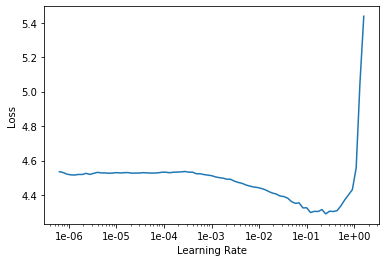

In [0]:
learn = load_learner(path,generator_learn_pkl_name)
#setup for text generation - prompts & number of words in each generated review
TOKENS = ["xxbos","What are the main characteristics of transfer pricing law and policy in your jurisdiction ?","what are the main legislation and regulatory authorities for pharmaceuticals in your jurisdiction ?","What is patent infringement in Japan?","How to register a copyight in China?", "What is patent infringment in Canada?","if", "i was", "what"]
N_SENT = len(TOKENS)
N_WORDS = 100 
temp = 0.8


def predict(learn, text, n_words=1, temp=1., top1=False, min_p=None, sep=' ', decoder=decode_spec_tokens):
    '''
    Based on fastai implementation.
    For every word, gets the network activations, sets unknown token to 0,
    only considers tokens above a certain value, then either returns the token
    with the highest activation or samples from the distribution of activations.
    '''
    learn.model.reset()
    xb,yb = learn.data.one_item(text)
    new_idx = []
    for _ in range(n_words):
        res = learn.pred_batch(batch=(xb,yb))[0][-1]
        res[learn.data.vocab.stoi[UNK]] = 0.
        if min_p is not None: res[res < min_p] = 0.
        res.pow_(1 / temp)
        if top1: idx = torch.argmax(res).item() # greedy decoding
        else: idx = torch.multinomial(res, 1).item()
        new_idx.append(idx)
        xb = xb.new_tensor([idx])[None]
    return '[' + text + ']' + sep + sep.join(decoder(learn.data.vocab.textify(new_idx, sep=None)))
    
def beam_search(learn, text, n_words=1, top_k=10, beam_sz=1000, temp=1., sep=' ', decoder=decode_spec_tokens):
    '''
    Based on fastai implementation.
    Performs beam search using provided parameters,
    returns either the sentence with the highest probability
    or samples from the distribution of probabilities.
    '''
    learn.model.reset()
    learn.model.eval()
    xb, yb = learn.data.one_item(text)
    nodes = None
    nodes = xb.clone()
    scores = xb.new_zeros(1).float()
    with torch.no_grad():
        for k in progress_bar(range(n_words), leave=False):
            out = F.log_softmax(learn.model(xb)[0][:,-1], dim=-1)
            out[:,learn.data.vocab.stoi[UNK]] = -float('Inf')
            values, indices = out.topk(top_k, dim=-1)
            scores = (-values + scores[:,None]).view(-1)
            indices_idx = torch.arange(0,nodes.size(0))[:,None].expand(nodes.size(0), top_k).contiguous().view(-1)
            sort_idx = scores.argsort()[:beam_sz]
            scores = scores[sort_idx]
            nodes = torch.cat([nodes[:,None].expand(nodes.size(0),top_k,nodes.size(1)),
                            indices[:,:,None].expand(nodes.size(0),top_k,1),], dim=2)
            nodes = nodes.view(-1, nodes.size(2))[sort_idx]
            learn.model[0].select_hidden(indices_idx[sort_idx])
            xb = nodes[:,-1][:,None]
    #print(scores)
    scores -= scores.max()
    node_idx = torch.multinomial(torch.exp(-scores / temp), 1).item()
    #node_idx = torch.argmax(scores) # returns top candidate instead of multinomial
    return '[' + text + ']' + sep + sep.join(decoder(
        learn.data.vocab.textify([i.item() for i in nodes[node_idx][2:]], sep=None)))
    
def predict_topk(learn, text, n_words=1, k=5, temp=1., min_p=None, sep=' ', decoder=decode_spec_tokens):
    '''
    Performs top-k sampling:
    selects the top-k probabilities, and then
    samples from their probability distribution and returns the token.
    '''
    learn.model.reset()
    xb,yb = learn.data.one_item(text)
    new_idx = []
    for _ in range(n_words):
        outp = learn.pred_batch(batch=(xb,yb))[0][-1]
        outp[learn.data.vocab.stoi[UNK]] = 0.
        if min_p is not None: outp[outp < min_p] = 0.
        probs = F.softmax(outp / temp,dim=-1)
        vals,idxs = probs.topk(k, dim=-1)
        idx = idxs[torch.multinomial(vals, 1).item()]
        new_idx.append(idx)
        xb = xb.new_tensor([idx])[None]
    return '[' + text + ']' + sep + sep.join(decoder(learn.data.vocab.textify(new_idx, sep=None)))
    

def predict_nucleus(learn, text, n_words=1, p=0.5, temp=1., min_p=None, sep=' ', decoder=decode_spec_tokens):
    '''
    Performs top-p sampling:
    finds the k which corresponds to the desired cumulative
    probability, then performs top-k sampling as above.
    '''
    learn.model.reset()
    xb,yb = learn.data.one_item(text)
    new_idx = []
    for _ in range(n_words):
        outp = learn.pred_batch(batch=(xb,yb))[0][-1]
        outp[learn.data.vocab.stoi[UNK]] = 0.
        if min_p is not None: outp[outp < min_p] = 0.
        probs = F.softmax(outp / temp, dim=-1) 
        cumsum_prob = (probs.sort(descending=True)[0]).cumsum(0)
        k = (cumsum_prob > p).nonzero().view(-1)[0].int() + 1
        vals,idxs = probs.topk(k, dim=-1)
        idx = idxs[torch.multinomial(vals, 1).item()]
        new_idx.append(idx)
        xb = xb.new_tensor([idx])[None]
    return '[' + text + ']' + sep + sep.join(decoder(learn.data.vocab.textify(new_idx, sep=None)))
#greedy top-1 prediction
print("\n\n".join(str(i+1) + ". " + predict(learn, TOKENS[i], N_WORDS, temp, True)
                  for i in range(N_SENT)))
#greedy multinomial prediction
print("\n\n".join(str(i+1) + ". " + predict(learn, TOKENS[i], N_WORDS, temp, False)
                  for i in range(N_SENT)))
#beam-search prediction
print("\n\n".join(str(i+1) + ". " + beam_search(learn, TOKENS[i], N_WORDS, top_k=6, beam_sz=20, temp=temp)
                  for i in range(N_SENT)))
#top-k prediction
print("\n\n".join(str(i+1) + ". " + predict_topk(learn, TOKENS[i], N_WORDS, 5, temp)
                  for i in range(N_SENT)))
#top-p prediction
print("\n\n".join(str(i+1) + ". " + predict_nucleus(learn, TOKENS[i], N_WORDS, p=1e-4, temp=temp)
                  for i in range(N_SENT)))

1. [xxbos] xxfld 1 What are the main regulatory provisions and legislation relevant to bribery and corruption ? xxfld 2 The main laws that regulate bribery and corruption are the : Criminal Code ( Criminal Code ) . Criminal Code ( Criminal Code ) . Criminal Code ( Criminal Code ) . Criminal Code ( Criminal Code ) . Criminal Code ( Criminal Code ) . Criminal Code ( Criminal Code ) . Criminal

2. [What are the main characteristics of transfer pricing law and policy in your jurisdiction ?] xxfld 2 The Transfer Pricing Guidelines for Transfer Pricing Guidelines are the main guidelines for transfer pricing . The Transfer Pricing Guidelines are the main guidelines for transfer pricing . The Transfer Pricing Guidelines are the main guidelines for transfer pricing . The Transfer Pricing Guidelines are the main guidelines for transfer pricing . The Transfer Pricing Guidelines are the main guidelines for transfer pricing . The Transfer Pricing Guidelines are the main

3. [what are the main legis

1. [xxbos] 1 xxbos xxfld 1 What are the most common forms of security granted over immovable and movable property ? What formalities must the security documents , secured creditor or debtor comply with ? What formalities must the security documents , secured creditor or debtor comply with ? What is the effect of non - compliance with these formalities ? xxfld 2 Immovable property Common forms of security . The most common forms of security over immovable property are : Immovable property . Immovable property . Immovable property . Immovable property .

2. [What are the main characteristics of transfer pricing law and policy in your jurisdiction ?] 1 What are the main characteristics of transfer pricing law and policy in your jurisdiction ? xxfld 2 The Transfer Pricing Guidelines for Multinational Enterprises and Tax Administrations 2010 ( OECD Transfer Pricing Guidelines ) and the Organisation for Economic Co - operation and Development 's ( OECD ) Transfer Pricing Guidelines for Multi

In [0]:
learn = load_learner(path,classifier_learn_pkl_name)
learn.predict("Saying I love you is not the way?")

(Category Private Client,
 tensor(57),
 tensor([2.5375e-04, 3.8776e-03, 1.8381e-03, 1.8112e-02, 1.6632e-03, 5.1722e-03,
         1.0969e-02, 2.0774e-03, 5.7489e-04, 3.8978e-03, 1.6776e-04, 3.0316e-02,
         2.0201e-03, 3.9130e-04, 4.9323e-02, 6.1449e-03, 4.0492e-04, 1.7972e-03,
         9.4644e-03, 2.2344e-03, 1.3849e-02, 1.7948e-02, 3.1613e-03, 3.8076e-04,
         5.8374e-03, 5.4975e-03, 7.2296e-03, 2.1122e-03, 2.9299e-03, 1.8569e-03,
         3.5710e-04, 2.8330e-03, 1.4186e-02, 1.0900e-02, 1.6697e-03, 1.7961e-04,
         3.1464e-03, 3.4252e-03, 1.3921e-03, 1.2878e-03, 2.6038e-02, 1.1628e-03,
         6.1357e-02, 2.9617e-03, 2.1229e-02, 8.6432e-04, 1.1964e-02, 3.3701e-04,
         5.0609e-03, 6.9177e-03, 9.1055e-04, 1.6456e-02, 3.0598e-03, 9.9650e-03,
         3.7640e-03, 1.7503e-03, 1.7476e-02, 1.9634e-01, 5.4474e-03, 6.0079e-03,
         5.1210e-02, 1.0352e-01, 1.4433e-02, 2.2234e-03, 8.9674e-04, 1.1063e-04,
         3.2186e-03, 3.4749e-02, 2.0704e-02, 2.7181e-03, 1.7826e-02, 4